<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/LED_Light_Bulb_Surface_Temperature_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%writefile led_touch_temp.py
"""
Physically informed LED lamp surface-temperature predictor.

We solve for steady-state surface temperature T_s by balancing:
    Q_gen = q_conv + q_rad + q_cond

Where:
- Q_gen = P_in - f_escape * P_light
    with P_in = L / LE_lamp, P_light = L / LER
- q_conv = h(T_s, T_a, geometry) * A * (T_s - T_a)
    h via Churchill–Chu free-convection correlations in air
- q_rad = epsilon * sigma * A * (T_s^4 - T_a^4)
- q_cond = G_extra * (T_s - T_a)   (fixture conduction “escape” path)

Units:
- Temperatures in Kelvin internally
- Areas in m^2, lengths in m, power in W
- Lumens (L), luminous efficacy LE_lamp (lm/W), LER (lm/W)

References (classic correlations):
- Churchill & Chu (1975): Free convection correlations for plates, cylinders, spheres.
- Incropera et al., "Fundamentals of Heat and Mass Transfer".
"""

from __future__ import annotations

from dataclasses import dataclass
from typing import Literal, Iterable, List
import math
import numpy as np

# Physical constants
SIGMA_SB = 5.670374419e-8  # Stefan–Boltzmann [W/(m^2 K^4)]
G = 9.80665                # Gravity [m/s^2]
P_ATM = 101_325.0          # Standard pressure [Pa]
R_AIR = 287.058            # Gas constant air [J/(kg K)]
CP_AIR = 1006.43           # Specific heat of air at ~300 K [J/(kg K)]

Geometry = Literal["vertical_plate", "horizontal_cylinder", "sphere"]


@dataclass
class ThermalScenario:
    """
    Bundle of geometric and radiative parameters for the lamp body.
    """
    name: str = "Default"
    area_m2: float = 0.005               # Exposed radiating/convecting area [m^2]
    char_length_m: float = 0.10          # Characteristic length for free convection [m]
    emissivity: float = 0.90             # Surface emissivity [–]
    geometry: Geometry = "vertical_plate"
    extra_conductance_w_per_k: float = 0.0  # Additional conduction path to ambient [W/K]


def celsius_to_kelvin(t_c: float) -> float:
    """Convert Celsius to Kelvin."""
    return t_c + 273.15


def kelvin_to_celsius(t_k: float) -> float:
    """Convert Kelvin to Celsius."""
    return t_k - 273.15


def air_properties(t_k: float, p_pa: float = P_ATM) -> dict:
    """
    Return air properties at film temperature t_k using simple correlations:
    - Dynamic viscosity via Sutherland's law.
    - Density via ideal gas.
    - Thermal conductivity via μ*cp/Pr with Pr self-consistently evaluated.
    This keeps consistency without external libs while remaining accurate enough
    for free-convection estimates near room temperature.
    """
    # Sutherland parameters for air
    mu0 = 1.716e-5     # Pa·s at T0
    t0 = 273.15        # K
    s = 111.0          # Sutherland constant [K]

    mu = mu0 * ((t_k / t0) ** 1.5) * (t0 + s) / (t_k + s)  # dynamic viscosity [Pa·s]
    rho = p_pa / (R_AIR * t_k)                             # density [kg/m^3]
    nu = mu / rho                                          # kinematic viscosity [m^2/s]
    # Start with Pr ≈ 0.71 to estimate k, then refine Pr
    pr_guess = 0.71
    k = mu * CP_AIR / pr_guess                             # thermal conductivity [W/(m K)]
    alpha = k / (rho * CP_AIR)                             # thermal diffusivity [m^2/s]
    pr = nu / alpha                                        # refined Pr
    # Recompute k once with refined Pr for consistency (minor change)
    k = mu * CP_AIR / pr
    alpha = k / (rho * CP_AIR)
    pr = nu / alpha

    return {"mu": mu, "rho": rho, "nu": nu, "k": k, "alpha": alpha, "pr": pr}


def _churchill_chu_vertical_plate(ra: float, pr: float) -> float:
    """
    Churchill & Chu correlation for vertical plate (laminar→turbulent, 1e-1≲Ra≲1e12):
    Nu = [ 0.825 + (0.387 Ra^{1/6}) / (1 + (0.492/Pr)^{9/16})^{8/27} ]^2
    """
    term = 0.387 * (ra ** (1.0 / 6.0)) / ((1.0 + (0.492 / pr) ** (9.0 / 16.0)) ** (8.0 / 27.0))
    nu = (0.825 + term) ** 2
    return max(nu, 0.0)


def _churchill_chu_horizontal_cylinder(ra: float, pr: float) -> float:
    """
    Churchill & Chu correlation for horizontal cylinder:
    Nu = 0.60 + [ 0.387 Ra^{1/6} / (1 + (0.559/Pr)^{9/16})^{8/27} ]^2
    """
    term = 0.387 * (ra ** (1.0 / 6.0)) / ((1.0 + (0.559 / pr) ** (9.0 / 16.0)) ** (8.0 / 27.0))
    nu = 0.60 + term ** 2
    return max(nu, 0.0)


def _churchill_chu_sphere(ra: float, pr: float) -> float:
    """
    Churchill correlation for sphere in free convection:
    Nu = 2 + 0.589 Ra^{1/4} / (1 + (0.469/Pr)^{9/16})^{4/9}
    """
    term = 0.589 * (ra ** 0.25) / ((1.0 + (0.469 / pr) ** (9.0 / 16.0)) ** (4.0 / 9.0))
    nu = 2.0 + term
    return max(nu, 0.0)


def h_free_convection(ts_k: float, ta_k: float, scenario: ThermalScenario) -> float:
    """
    Compute free-convection heat transfer coefficient h [W/(m^2 K)]
    for the given geometry using Churchill–Chu correlations.
    """
    t_film = 0.5 * (ts_k + ta_k)
    props = air_properties(t_film)
    pr = props["pr"]
    nu = props["nu"]
    k = props["k"]
    l = max(scenario.char_length_m, 1e-4)

    # Rayleigh number Ra = g * beta * ΔT * L^3 / (nu * alpha); beta ≈ 1/T_film
    beta = 1.0 / max(t_film, 1e-6)
    delta_t = max(ts_k - ta_k, 1e-9)
    alpha = props["alpha"]
    ra = G * beta * delta_t * (l ** 3) / (nu * alpha + 1e-30)

    if scenario.geometry == "vertical_plate":
        nu_nondim = _churchill_chu_vertical_plate(ra, pr)
    elif scenario.geometry == "horizontal_cylinder":
        nu_nondim = _churchill_chu_horizontal_cylinder(ra, pr)
    elif scenario.geometry == "sphere":
        nu_nondim = _churchill_chu_sphere(ra, pr)
    else:
        raise ValueError(f"Unsupported geometry: {scenario.geometry}")

    h = nu_nondim * k / l
    return max(h, 0.0)


def heat_generated_w(
    lumens: float,
    le_lamp_lm_per_w: float = 120.0,
    ler_lm_per_w: float = 275.0,
    light_escape_fraction: float = 0.90,
) -> float:
    """
    Compute internal heat generation (W) from photometric parameters.
    Q_gen = (L / LE_lamp) - f_escape * (L / LER).
    Clip at >= 0 for numerical safety.
    """
    pin = lumens / max(le_lamp_lm_per_w, 1e-9)
    p_light_escape = light_escape_fraction * lumens / max(ler_lm_per_w, 1e-9)
    q = pin - p_light_escape
    return max(q, 0.0)


def solve_surface_temperature_c(
    lumens: float,
    ambient_c: float,
    scenario: ThermalScenario,
    le_lamp_lm_per_w: float = 120.0,
    ler_lm_per_w: float = 275.0,
    light_escape_fraction: float = 0.90,
) -> float:
    """
    Solve steady-state surface temperature in Celsius by 1D energy balance:
      Q_gen = h*A*(T_s - T_a) + eps*sigma*A*(T_s^4 - T_a^4) + G_extra*(T_s - T_a)
    Unknown is T_s. We use a robust bisection root finder.
    """
    ta_k = celsius_to_kelvin(ambient_c)
    q_gen = heat_generated_w(
        lumens, le_lamp_lm_per_w=le_lamp_lm_per_w,
        ler_lm_per_w=ler_lm_per_w, light_escape_fraction=light_escape_fraction
    )

    if q_gen <= 0.0:
        return ambient_c

    area = max(scenario.area_m2, 1e-8)
    eps = min(max(scenario.emissivity, 0.0), 1.0)
    g_extra = max(scenario.extra_conductance_w_per_k, 0.0)

    def residual(ts_k: float) -> float:
        """Energy-balance residual f(T_s) to be driven to zero."""
        h = h_free_convection(ts_k, ta_k, scenario)
        q_conv = h * area * (ts_k - ta_k)
        q_rad = eps * SIGMA_SB * area * (ts_k**4 - ta_k**4)
        q_cond = g_extra * (ts_k - ta_k)
        return q_conv + q_rad + q_cond - q_gen

    # Bisection bracket
    low = ta_k
    high = ta_k + 300.0  # up to +300 K rise, ample for this problem
    f_low = residual(low)
    f_high = residual(high)
    # Ensure sign change; expand if needed
    while f_high < 0.0 and high - ta_k < 1000.0:
        high += 100.0
        f_high = residual(high)

    # If still no sign change (extremely tiny Q), return ambient
    if f_low <= 0.0 and f_high <= 0.0:
        return ambient_c

    # Bisection
    for _ in range(80):
        mid = 0.5 * (low + high)
        f_mid = residual(mid)
        if f_mid > 0.0:
            high = mid
        else:
            low = mid
        if abs(high - low) < 1e-6:
            break

    ts_k = 0.5 * (low + high)
    return kelvin_to_celsius(ts_k)


def predict_series(
    lumens_values: Iterable[float],
    ambient_c: float,
    scenario: ThermalScenario,
    le_lamp_lm_per_w: float = 120.0,
    ler_lm_per_w: float = 275.0,
    light_escape_fraction: float = 0.90,
) -> np.ndarray:
    """
    Vectorized convenience wrapper: compute surface temperature [°C] for many lumens.
    """
    temps = []
    for l in lumens_values:
        t_c = solve_surface_temperature_c(
            lumens=float(l),
            ambient_c=ambient_c,
            scenario=scenario,
            le_lamp_lm_per_w=le_lamp_lm_per_w,
            ler_lm_per_w=ler_lm_per_w,
            light_escape_fraction=light_escape_fraction,
        )
        temps.append(t_c)
    return np.array(temps, dtype=float)


def classify_touch_temp(t_c: float) -> str:
    """
    Human-centric classification for touch sensation at ~33 °C skin temperature.
    """
    if t_c < 35.0:
        return "cool / neutral"
    if t_c < 42.0:
        return "warm"
    if t_c < 50.0:
        return "hot"
    return "very hot"


__all__ = [
    "ThermalScenario",
    "solve_surface_temperature_c",
    "predict_series",
    "classify_touch_temp",
    "heat_generated_w",
]

Writing led_touch_temp.py


In [2]:
!pip -q install pylint
!pylint led_touch_temp.py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 523.2/523.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.6/275.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 4.5 MB/s eta 0:00:00
************* Module led_touch_temp
led_touch_temp.py:173:0: R0913: Too many arguments (6/5) (too-many-arguments)
led_touch_temp.py:173:0: R0917: Too many positional arguments (6/5) (too-many-positional-arguments)
led_touch_temp.py:173:0: R0914: Too many local variables (19/15) (too-many-locals)
led_touch_temp.py:236:0: R0913: Too many arguments (6/5) (too-many-arguments)
led_touch_temp.py:236:0: R0917: Too many positional arguments (6/5) (too-many-positional-arguments)
led_touch_temp.py:28:0: W0611: Unused List imported from typing (unused-import)
led_touch_temp.py:29:0: W0611: Unused import math (unused-import)

-----------------------------------
Your code has been rated at 9.43/10



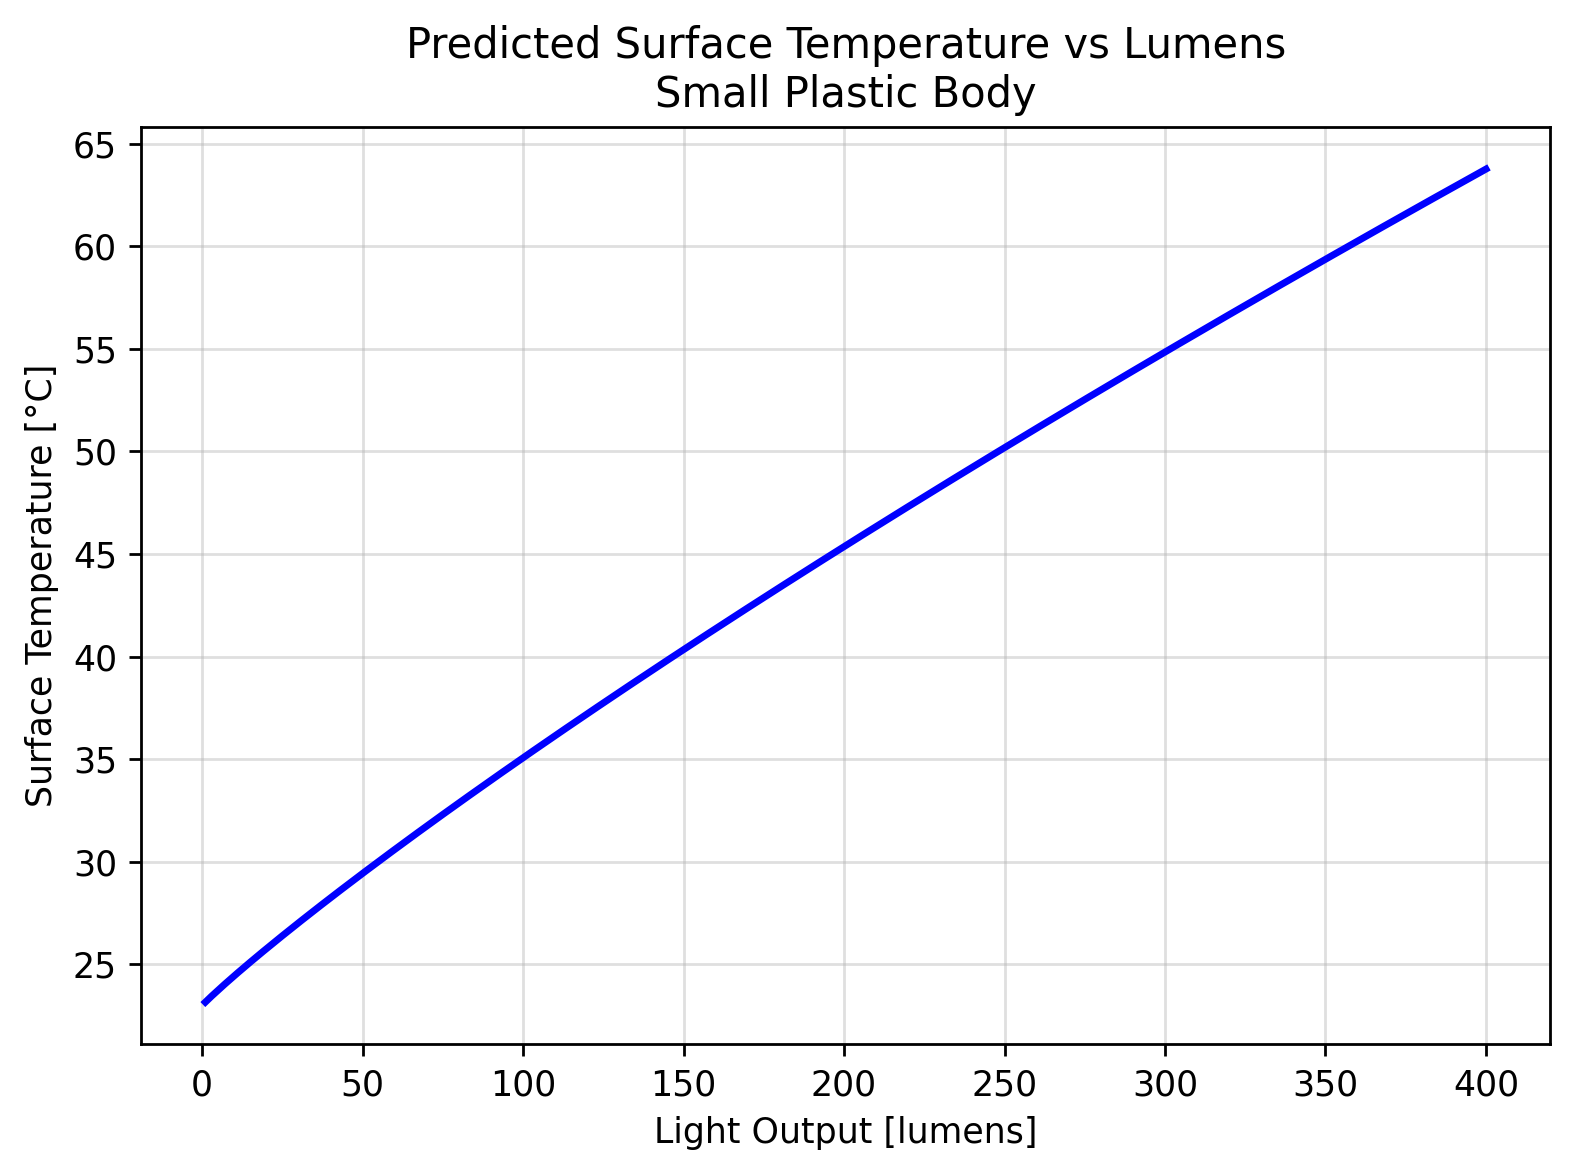

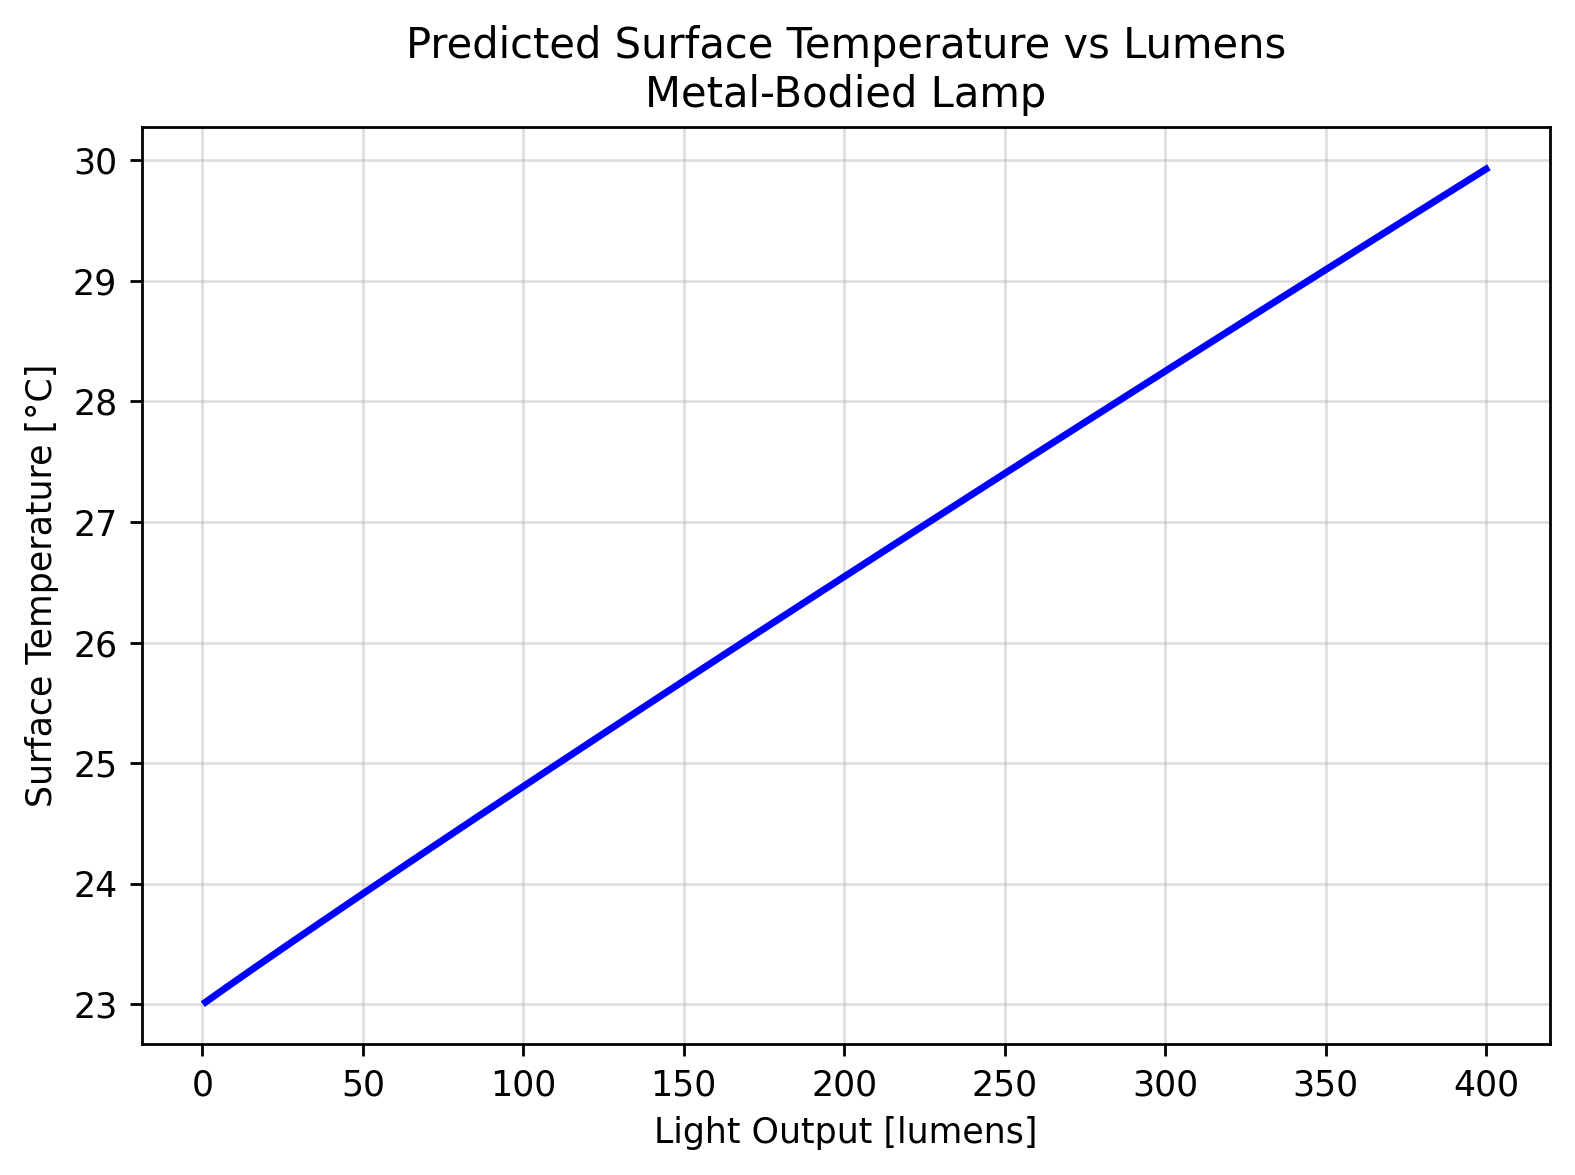

     Scenario  Lumens  Ambient [°C]  LE_lamp [lm/W]  LER [lm/W]  Light Escape f  Surface Temp [°C] Touch Category
Small plastic    10.0          23.0           120.0       275.0             0.9              24.44 cool / neutral
Small plastic    50.0          23.0           120.0       275.0             0.9              29.44 cool / neutral
Small plastic   200.0          23.0           120.0       275.0             0.9              45.36            hot
   Metal body    10.0          23.0           120.0       275.0             0.9              23.19 cool / neutral
   Metal body    50.0          23.0           120.0       275.0             0.9              23.92 cool / neutral
   Metal body   200.0          23.0           120.0       275.0             0.9              26.55 cool / neutral


In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from led_touch_temp import (
    ThermalScenario,
    predict_series,
    solve_surface_temperature_c,
    classify_touch_temp,
)

# ---- Matplotlib rcParams: 250 dpi and blue line color ----
mpl.rcParams["figure.dpi"] = 250
mpl.rcParams["savefig.dpi"] = 250
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=["blue"])  # default line color blue

# ---- Photometric & environment defaults (adjust as needed) ----
AMBIENT_C = 23.0                 # room temperature [°C]
LE_LAMP = 120.0                  # luminous efficacy of whole lamp [lm/W]
LER = 275.0                      # luminous efficacy of radiation [lm/W]
F_ESCAPE = 0.90                  # fraction of emitted light escaping without heating the body

# ---- Two illustrative scenarios ----
small_plastic = ThermalScenario(
    name="Small plastic night-light\n(compact body)",
    area_m2=0.003,               # ~ palm-sized surface
    char_length_m=0.06,          # ~ 6 cm characteristic length
    emissivity=0.90,
    geometry="vertical_plate",
    extra_conductance_w_per_k=0.01,  # minor conduction into base
)

metal_body = ThermalScenario(
    name="Metal-bodied lamp\n(larger area / heatsink)",
    area_m2=0.010,               # more area to shed heat
    char_length_m=0.12,          # ~ 12 cm characteristic length
    emissivity=0.90,
    geometry="vertical_plate",
    extra_conductance_w_per_k=0.20,  # better conduction path to fixture
)

# ---- Define lumen sweep and compute ----
lumens = np.linspace(1.0, 400.0, 200)  # 1 → 400 lm range

temps_plastic = predict_series(
    lumens, AMBIENT_C, small_plastic, le_lamp_lm_per_w=LE_LAMP,
    ler_lm_per_w=LER, light_escape_fraction=F_ESCAPE
)
temps_metal = predict_series(
    lumens, AMBIENT_C, metal_body, le_lamp_lm_per_w=LE_LAMP,
    ler_lm_per_w=LER, light_escape_fraction=F_ESCAPE
)

# ---- Plot #1: small plastic body (blue line) ----
plt.figure()
plt.plot(lumens, temps_plastic, linewidth=2.0)
plt.title("Predicted Surface Temperature vs Lumens\nSmall Plastic Body")
plt.xlabel("Light Output [lumens]")
plt.ylabel("Surface Temperature [°C]")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

# ---- Plot #2: metal body (blue line) ----
plt.figure()
plt.plot(lumens, temps_metal, linewidth=2.0)
plt.title("Predicted Surface Temperature vs Lumens\nMetal-Bodied Lamp")
plt.xlabel("Light Output [lumens]")
plt.ylabel("Surface Temperature [°C]")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

# ---- Report table for the key points you asked about ----
check_lm = [10.0, 50.0, 200.0]
rows = []
for label, scen in [
    ("Small plastic", small_plastic),
    ("Metal body", metal_body),
]:
    for L in check_lm:
        t_c = solve_surface_temperature_c(
            lumens=L,
            ambient_c=AMBIENT_C,
            scenario=scen,
            le_lamp_lm_per_w=LE_LAMP,
            ler_lm_per_w=LER,
            light_escape_fraction=F_ESCAPE,
        )
        rows.append({
            "Scenario": label,
            "Lumens": L,
            "Ambient [°C]": AMBIENT_C,
            "LE_lamp [lm/W]": LE_LAMP,
            "LER [lm/W]": LER,
            "Light Escape f": F_ESCAPE,
            "Surface Temp [°C]": round(float(t_c), 2),
            "Touch Category": classify_touch_temp(float(t_c)),
        })

df = pd.DataFrame(rows)
# Present as a full table (no truncation)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
print(df.to_string(index=False))

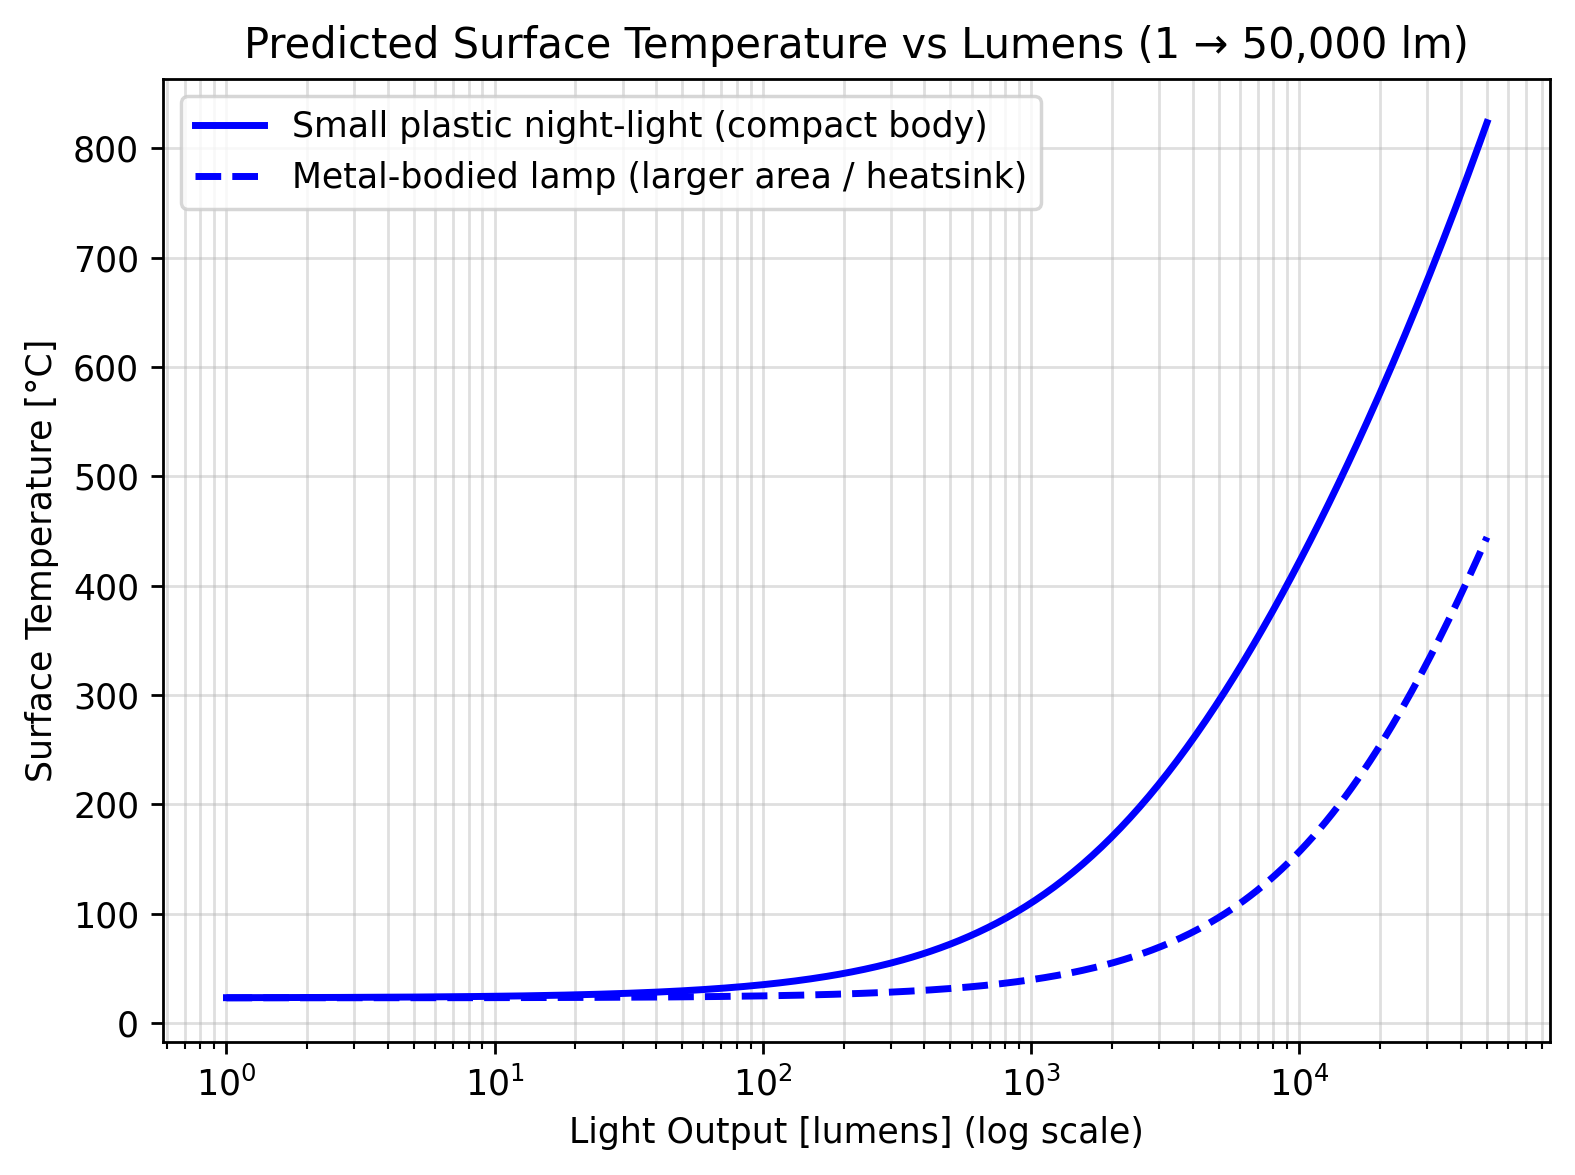

In [4]:
# Extended plot to 50,000 lumens using the same physics model as before.

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from led_touch_temp import ThermalScenario, predict_series

# --- Keep plotting configuration exactly as requested: 250 dpi and blue line color ---
mpl.rcParams["figure.dpi"] = 250
mpl.rcParams["savefig.dpi"] = 250
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=["blue"])  # all lines blue by default

# --- Photometric & environment defaults (match earlier assumptions) ---
AMBIENT_C = 23.0         # room temperature [°C]
LE_LAMP = 120.0          # luminous efficacy of whole lamp [lm/W]
LER = 275.0              # luminous efficacy of radiation [lm/W]
F_ESCAPE = 0.90          # fraction of emitted light escaping without reheating the body

# --- Recreate the two illustrative scenarios from the earlier cell ---
small_plastic = ThermalScenario(
    name="Small plastic night-light (compact body)",
    area_m2=0.003,            # ~ palm-sized surface
    char_length_m=0.06,        # ~ 6 cm characteristic length
    emissivity=0.90,
    geometry="vertical_plate",
    extra_conductance_w_per_k=0.01,  # minor conduction into base
)

metal_body = ThermalScenario(
    name="Metal-bodied lamp (larger area / heatsink)",
    area_m2=0.010,             # more area to shed heat
    char_length_m=0.12,         # ~ 12 cm characteristic length
    emissivity=0.90,
    geometry="vertical_plate",
    extra_conductance_w_per_k=0.20,  # better conduction path to fixture
)

# --- Define a geometric (log) sweep from 1 lm up to 50,000 lm ---
lumens_ext = np.geomspace(1.0, 5.0e4, 400)

# --- Compute predictions for both scenarios ---
temps_plastic_ext = predict_series(
    lumens_ext, AMBIENT_C, small_plastic,
    le_lamp_lm_per_w=LE_LAMP, ler_lm_per_w=LER, light_escape_fraction=F_ESCAPE
)
temps_metal_ext = predict_series(
    lumens_ext, AMBIENT_C, metal_body,
    le_lamp_lm_per_w=LE_LAMP, ler_lm_per_w=LER, light_escape_fraction=F_ESCAPE
)

# --- Single figure, both scenarios, both in blue, distinct linestyles ---
plt.figure()
plt.plot(lumens_ext, temps_plastic_ext, linestyle="-", linewidth=2.0, label=small_plastic.name)
plt.plot(lumens_ext, temps_metal_ext,   linestyle="--", linewidth=2.0, label=metal_body.name)
plt.xscale("log")
plt.title("Predicted Surface Temperature vs Lumens (1 → 50,000 lm)")
plt.xlabel("Light Output [lumens] (log scale)")
plt.ylabel("Surface Temperature [°C]")
plt.grid(True, which="both", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()